# Question A3

Find the optimal number of hidden neurons for first hidden layer of the 4-layer network (3 hidden layers, output layer) designed in Question 1 and 2

#### Plot the mean cross-validation accuracies on the final epoch for different numbers of hidden-layer neurons using a scatter plot. Limit the search space of the number of neurons to {64, 128, 256}. Continue using 5-fold cross validation on training dataset. Select the optimal number of neurons for the hidden layer. State the rationale for your selection.

This might take a while to run, approximately 20 - 30 min, so plan your time carefully.

1. Firstly, we import relevant libraries.

In [1]:
import tqdm
import time
import random
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import torch
from torch import nn
from torch.utils.data import Dataset
from torch.utils.data import DataLoader

from scipy.io import wavfile as wav

from sklearn import preprocessing
from sklearn.model_selection import KFold
from sklearn.model_selection import train_test_split
from sklearn.metrics import f1_score, precision_score, recall_score, confusion_matrix
from common_utils import set_seed

# setting seed
seed = 69
set_seed(seed)


2. To reduce repeated code, place your

- network (MLP defined in QA1)
- torch datasets (CustomDataset defined in QA1)
- loss function (loss_fn defined in QA1)

in a separate file called **common_utils.py**

Import them into this file. You will not be repenalised for any error in QA1 here as the code in QA1 will not be remarked.

The following code cell will not be marked.

In [2]:
from common_utils import (
    CustomDataset,
    loss_fn,
    generate_cv_folds_for_batch_sizes,
    split_dataset,
    preprocess_dataset,
)

dropout_rate = 0.2
test_size = 0.3


class MLP(nn.Module):
    def __init__(self, no_features, no_first_hidden, no_hidden, no_labels):
        super().__init__()
        self.mlp_stack = nn.Sequential(
            nn.Linear(no_features, no_first_hidden),
            nn.ReLU(),
            nn.Dropout(dropout_rate),
            nn.Linear(no_first_hidden, no_hidden),
            nn.ReLU(),
            nn.Dropout(dropout_rate),
            nn.Linear(no_hidden, no_hidden),
            nn.ReLU(),
            nn.Dropout(dropout_rate),
            nn.Linear(no_hidden, no_labels),
            nn.Sigmoid(),
        )

    def forward(self, x):
        logits = self.mlp_stack(x)
        return logits


df = pd.read_csv("simplified.csv")
df["label"] = df["filename"].str.split("_").str[-2]
X_train, y_train, X_test, y_test = split_dataset(
    df, ["filename", "label"], test_size, seed
)
X_train_scaled, X_test_scaled = preprocess_dataset(X_train, X_test)


3. Perform hyperparameter tuning for the different neurons with 5-fold cross validation.

In [3]:
from common_utils import train_loop, test_loop, test_loop as val_loop, EarlyStopper

no_folds = 5
max_epochs = 100
patience = 3
learning_rate = 0.001


def train(model, X_train_scaled, y_train2, X_val_scaled, y_val2, batch_size):
    final_val_accuracies = []

    optimizer = torch.optim.Adam(model.parameters(), learning_rate)
    early_stopper = EarlyStopper(patience)

    for exp in range(no_folds):
        X_train_folds = X_train_scaled[exp]
        y_train_folds = y_train2[exp]
        X_val_folds = X_val_scaled[exp]
        y_val_folds = y_val2[exp]

        training_data = CustomDataset(X_train_folds, y_train_folds)
        validation_data = CustomDataset(X_val_folds, y_val_folds)
        train_dataloader = DataLoader(
            training_data, batch_size=batch_size, shuffle=True
        )
        val_dataloader = DataLoader(
            validation_data, batch_size=batch_size, shuffle=True
        )

        final_val_accuracy = 0.0

        for _epoch in range(max_epochs):
            train_loop(train_dataloader, model, loss_fn, optimizer)

            val_loss, val_accuracy = val_loop(val_dataloader, model, loss_fn)
            final_val_accuracy = val_accuracy

            if early_stopper.early_stop(val_loss):
                break

        final_val_accuracies.append(final_val_accuracy)

        print(
            f"Experiment {exp + 1}: Final_val_accuracy: {(100*final_val_accuracy):>0.2f}%"
        )

    mean_cv_accuracy = np.mean(np.array(final_val_accuracies), axis=0)

    print(f"Done! Mean_cv_accuracy: {(100*mean_cv_accuracy):>0.2f}%")

    return mean_cv_accuracy


In [4]:
optimal_bs = 128
num_neurons = [64, 128, 256]


def find_optimal_hyperparameter(X_train, y_train, parameters, _mode, batch_size):
    cv_accuracies = []

    for num_neurons_ in parameters:
        print(f"Number of neurons {num_neurons_}:")

        (
            X_train_scaled_dict,
            X_val_scaled_dict,
            y_train_dict,
            y_val_dict,
        ) = generate_cv_folds_for_batch_sizes([batch_size], X_train, y_train)
        model = MLP(
            no_features=77, no_first_hidden=num_neurons_, no_hidden=128, no_labels=1
        )

        mean_cv_accuracy = train(
            model,
            X_train_scaled_dict[batch_size],
            y_train_dict[batch_size],
            X_val_scaled_dict[batch_size],
            y_val_dict[batch_size],
            batch_size,
        )

        cv_accuracies.append(mean_cv_accuracy)

    return cv_accuracies, []


cross_validation_accuracies, cross_validation_times = find_optimal_hyperparameter(
    X_train.to_numpy(), y_train, num_neurons, "num_neurons", optimal_bs
)


Number of neurons 64:
Experiment 1: Final_val_accuracy: 66.77%
Experiment 2: Final_val_accuracy: 72.39%
Experiment 3: Final_val_accuracy: 72.93%
Experiment 4: Final_val_accuracy: 73.22%
Experiment 5: Final_val_accuracy: 75.70%
Done! Mean_cv_accuracy: 72.20%
Number of neurons 128:
Experiment 1: Final_val_accuracy: 68.54%
Experiment 2: Final_val_accuracy: 78.02%
Experiment 3: Final_val_accuracy: 81.87%
Experiment 4: Final_val_accuracy: 82.64%
Experiment 5: Final_val_accuracy: 85.71%
Done! Mean_cv_accuracy: 79.36%
Number of neurons 256:
Experiment 1: Final_val_accuracy: 69.31%
Experiment 2: Final_val_accuracy: 80.86%
Experiment 3: Final_val_accuracy: 82.58%
Experiment 4: Final_val_accuracy: 84.60%
Experiment 5: Final_val_accuracy: 87.02%
Done! Mean_cv_accuracy: 80.88%


4. Plot the cross-validation accuracies against the number of epochs for different numbers of hidden-layer neurons. Limit the search space of the number of neurons to {64, 128, 256}.

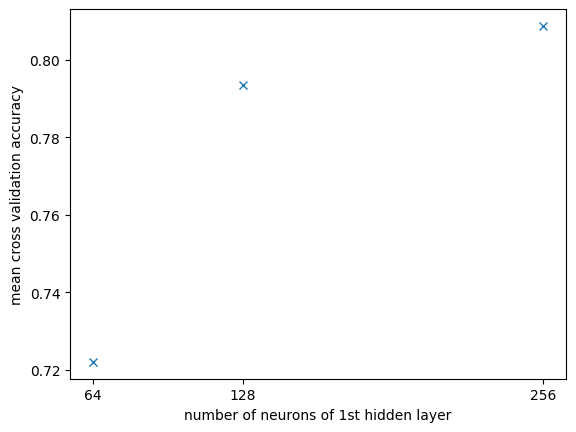

In [5]:
plt.figure(1)
plt.plot(num_neurons, cross_validation_accuracies, marker="x", linestyle="None")
plt.xticks(num_neurons)
plt.xlabel("number of neurons of 1st hidden layer")
plt.ylabel("mean cross validation accuracy")
plt.show()



5. Select the optimal number of neurons for the hidden layer. State the rationale for your selection.

In [6]:
optimal_neurons = 256
reason = "Highest mean cross validation accuracy"


6. Plot the train and test accuracies against training epochs with the optimal number of neurons using a line plot.

Epoch 1: Train_accuracy: 54.37%, Test_accuracy: 57.05%, Test_loss: 0.005443
Epoch 2: Train_accuracy: 59.38%, Test_accuracy: 58.84%, Test_loss: 0.005298
Epoch 3: Train_accuracy: 61.14%, Test_accuracy: 62.77%, Test_loss: 0.005222
Epoch 4: Train_accuracy: 64.33%, Test_accuracy: 62.94%, Test_loss: 0.005100
Epoch 5: Train_accuracy: 66.19%, Test_accuracy: 65.40%, Test_loss: 0.004984
Epoch 6: Train_accuracy: 68.18%, Test_accuracy: 65.31%, Test_loss: 0.005003
Epoch 7: Train_accuracy: 69.96%, Test_accuracy: 66.58%, Test_loss: 0.004904
Epoch 8: Train_accuracy: 71.51%, Test_accuracy: 67.19%, Test_loss: 0.004881
Epoch 9: Train_accuracy: 73.34%, Test_accuracy: 68.41%, Test_loss: 0.004860
Epoch 10: Train_accuracy: 75.49%, Test_accuracy: 68.63%, Test_loss: 0.004777
Epoch 11: Train_accuracy: 75.58%, Test_accuracy: 69.54%, Test_loss: 0.004709
Epoch 12: Train_accuracy: 76.74%, Test_accuracy: 69.13%, Test_loss: 0.004719
Epoch 13: Train_accuracy: 78.75%, Test_accuracy: 69.65%, Test_loss: 0.004905
Epoch 14

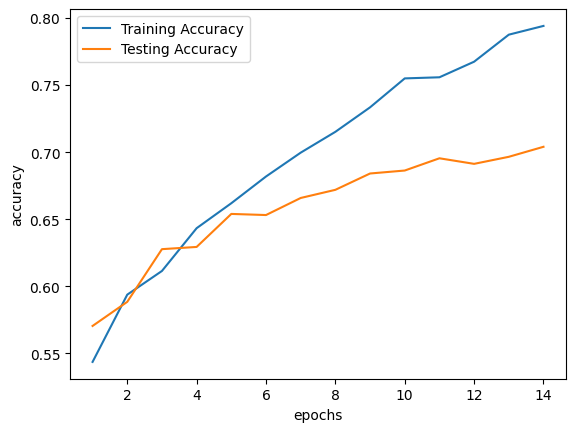

In [7]:
import matplotlib.pyplot as plt

training_data = CustomDataset(X_train_scaled, y_train)
testing_data = CustomDataset(X_test_scaled, y_test)
train_dataloader = DataLoader(training_data, batch_size=optimal_bs, shuffle=True)
test_dataloader = DataLoader(testing_data, batch_size=optimal_bs, shuffle=True)

train_accuracies = []
test_accuracies = []

model = MLP(no_features=77, no_first_hidden=optimal_neurons, no_hidden=128, no_labels=1)
optimizer = torch.optim.Adam(model.parameters(), learning_rate)
early_stopper = EarlyStopper(patience)

for epoch in range(max_epochs):
    _train_loss, train_correct = train_loop(train_dataloader, model, loss_fn, optimizer)
    test_loss, test_correct = test_loop(test_dataloader, model, loss_fn)

    train_accuracies.append(train_correct)
    test_accuracies.append(test_correct)

    print(
        f"Epoch {epoch+1}: Train_accuracy: {(100*train_correct):>0.2f}%, Test_accuracy: {(100*test_correct):>0.2f}%, Test_loss: {test_loss:>8f}"
    )

    if early_stopper.early_stop(test_loss):
        print("Done!")
        break

torch.save(model, 'model.pth')

acc_fig = plt.figure(2)
plt.plot(
    range(1, len(train_accuracies) + 1), train_accuracies, label="Training Accuracy"
)
plt.plot(range(1, len(test_accuracies) + 1), test_accuracies, label="Testing Accuracy")
plt.xlabel("epochs")
plt.ylabel("accuracy")
plt.legend()
plt.show()
